In [1]:
import pandas as pd
import numpy as np
import time
import copy
import datetime
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\mberezhnyak\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NeighbourhoodCleaningRule

In [3]:
course_id = 'KNU/101/2014_T2'
user_id = 50444
sm = pd.read_csv('data\courseware_studentmodule.csv')

In [4]:
users = pd.read_csv('data\userprofile.csv',encoding = 'utf8')

In [5]:
cert = pd.read_csv('data\certificates_generatedcertificate.csv')

C:\Users\mberezhnyak\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
related_columns = sm[(sm.module_type == 'problem') & (sm.course_id == course_id)].module_id.unique()

In [251]:
sm = sm[sm.module_type == 'problem']
sm = sm.rename(columns = {'student_id':'user_id'})
sm.grade = map(lambda x: x if x != '\\b' else 0,sm.grade.tolist())
cert = cert[cert.course_id == course_id]
registered = cert.user_id.unique()
users = users[users.id.isin(registered)]

In [252]:
userfeatures = pd.merge(cert, users,left_on='user_id',right_on='id')[['user_id_x','year_of_birth','level_of_education','gender','status']]

In [253]:
userfeatures

,user_id_x,year_of_birth,level_of_education,gender,status
0,47030,1993,b,f,downloadable
1,8,\b,\b,\b,downloadable
2,113,\b,NaN,NaN,notpassing
3,117,1991,a,m,notpassing
4,122,1994,a,m,notpassing
5,19,\b,a,m,notpassing
6,137,1995,hs,m,notpassing
7,138,1996,hs,m,notpassing
8,160,1993,a,m,notpassing
9,161,1991,m,f,downloadable


In [167]:
regions = pd.read_csv('regions.csv',encoding = 'utf8')
tokens = []
for i, row in enumerate(regions.region):
    if row == u'Одеська область':
        tokens.append(u'Одес')
    elif u'цька область' in row or u'ська область' in row or u'зька область' in row:
        tokens.append(row[0:-12])
    elif row == u'Автономна Республіка Крим':
        tokens.append(u'АРК')
    else:
        tokens.append(row)
regions['token1'] = tokens

tokens = []
for i, row in enumerate(regions.region):
    if row == u'Київ':
        tokens.append(u'Kyiv,Киів,Киiв,Kiyv,Киъв,Киїі,Kyev')
    elif row == u'Дніпро':
        tokens.append(u'Днiпропетровськ')
    elif row == 'Харків':
        tokens.append(u'Kharkiv')
    elif row == u'Львів':
        tokens.append(u'Львiв,L''viv')
    elif row == u'Запоріжжя':
        tokens.append(u'Запорiжжя,Zaporizhzhya')
    elif row == u'Вараш':
        tokens.append(u'Кузнецовськ')
    elif row == u'Донецьк':
        tokens.append(u'Donetsk')
    elif row == u'Одеса':
        tokens.append(u'Odesa')
    elif row == u'Кривий Ріг':
        tokens.append(u'Кривий Рiг')
    elif row == u'Миколаїв':
        tokens.append(u'Mykolaiv')
    else:
        tokens.append(row)
regions['token2'] = tokens

settlements = pd.read_csv('cities_ua.csv',encoding = 'utf8')
settlements = settlements[settlements.type == u'місто']
settlements = settlements[['settlement', u'region', u'type', u'English', u'Russian']]
settlementsWithCodes = pd.merge(settlements, regions, on=u'region')

C:\Users\mberezhnyak\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:20: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [168]:
usersWithAddress = users[~users.mailing_address.isnull()]
usersWithAddress = usersWithAddress[~usersWithAddress.mailing_address.str.contains('@')]
usersWithAddress = usersWithAddress[usersWithAddress.mailing_address != '\\b']
usersWithAddress = usersWithAddress.mailing_address

In [170]:
codes = []
for i, u in enumerate(usersWithAddress):
    address = u.lower()
    if i % 100 == 0:
        print i
    gotIt = False
    for j, row in settlementsWithCodes.iterrows():
        #print j
        #print row['settlement']
        tokenFound = False
        for t in row['token2'].split(','):
            if t.lower() in address:
                tokenFound = True
                break
        if tokenFound or \
        row['settlement'].lower() in address or \
        row['English'].lower() in address \
        or row['Russian'].lower() in address \
        or row['token1'].lower() in address:
            codes.append(row['code'])
            gotIt = True
            break
    if not gotIt:
        codes.append(u'no_data')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [171]:
ua = users[~users.mailing_address.isnull()]
ua = ua[~ua.mailing_address.str.contains('@')]
ua = ua[ua.mailing_address != '\\b']
ua['region_code'] = codes

In [240]:
ua[ua.region_code == u'no_data'].groupby(['mailing_address'])['mailing_address'].count().nlargest(20)

mailing_address
Москва             32
Варшава            31
Warszawa           14
Краків             12
Санкт-Петербург    12
Відень             11
Крим               10
с.Козацьке         10
Toronto             9
Котовськ            9
Минск               9
Україна             9
Харькiв             9
м.Кузнецовськ       9
Chernigiv           8
Krakow              8
Kremenchuk          8
Uzhhorod            8
Warsaw              8
Zaporizhya          8
Name: mailing_address, dtype: int64

In [245]:
#ua[ua.mailing_address == u'L\'viv']
#ua[ua.mailing_address == u'Житомир']
#ua.loc[ua.mailing_address ==u'Ружин', 'region_code'] = u'UA-18'
ua.to_csv('geomask.csv', index=False,encoding = 'utf8')

In [64]:
#fit
##__getProblemResultFeatures
start_time = time.time()
modules = sm.module_id.unique().tolist()
result = []
for module in modules:
    first = sm[sm.module_id == module].created.min()
    result.append({'name':module,'date':first})
labels = map(lambda x: x['name'],sorted(result,key=lambda x: x['date']))
rebased = sm.pivot(index='user_id',columns='module_id',values='grade')
rebased = rebased[labels].fillna(0)
res_features =  rebased
print '__getProblemResultFeatures finished in ' + str(time.time() - start_time)
##

__getProblemResultFeatures finished in 89.3380000591


In [66]:
##__getUserDataFeatures
start_time = time.time()
u = pd.DataFrame(users[['gender','year_of_birth','level_of_education']],index=users.user_id)
c = cert.set_index(cert.user_id)[['grade','status']]
c['status'] = c.apply(lambda x: 1 if x.status == 'downloadable' else 0,1)
u_features = c.join(u)
print '__getUserDataFeatures finished in ' + str(time.time() - start_time)
##

__getUserDataFeatures finished in 0.676000118256


In [67]:
len(res_features)

53013

In [68]:
##__lastPassedTest
start_time = time.time()
features = res_features.ix[user_id].tolist()
index = len(features)
for i in reversed(features):
    if i != 0:
        break
    index -= 1
if index == 0:
    index = len(res_features.columns)
last = index
print '__lastPassedTest finished in ' + str(time.time() - start_time)
##

__lastPassedTest finished in 0.00600004196167


In [69]:
start_time = time.time()
cols = res_features.columns[:last].tolist()
dataset = u_features.join(res_features)
data = dataset[cols].fillna(0)
Y = dataset.status
print '_final preparations finished in ' + str(time.time() - start_time)

_final preparations finished in 3.64800000191


In [70]:
model = GaussianNB()
start_time = time.time()
predicted = cross_val_predict(model, data, Y)
print 'cross_val_predict finished in ' + str(time.time() - start_time)

score = float(np.sum(predicted == Y))/len(data)
start_time = time.time()
model.fit(data,Y)
print 'fit finished in ' + str(time.time() - start_time)

cross_val_predict finished in 4.67900013924
fit finished in 1.35299992561


In [71]:
#predict

cols = res_features.columns.tolist()[:last]
start_time = time.time()
answer = model.predict(res_features[cols].ix[user_id].tolist())
print 'predict finished in ' + str(time.time() - start_time)
print score

predict finished in 0.570999860764
0.607830299856


C:\Users\mberezhnyak\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [58]:
#fit
##__getProblemResultFeatures
start_time = time.time()
modules = sm[sm.course_id == course_id].module_id.unique().tolist()
result = []
for module in modules:
    first = sm[sm.module_id == module].created.min()
    result.append({'name':module,'date':first})
labels = map(lambda x: x['name'],sorted(result,key=lambda x: x['date']))
rebased = sm.pivot(index='user_id',columns='module_id',values='grade')
rebased = rebased[labels].fillna(0)
res_features =  rebased
print '__getProblemResultFeatures finished in ' + str(time.time() - start_time)
##
##__getUserDataFeatures
start_time = time.time()
u = pd.DataFrame(users[['gender','year_of_birth','level_of_education']],index=users.user_id)
c = cert.set_index(cert.user_id)[['grade','status']]
c['status'] = c.apply(lambda x: 1 if x.status == 'downloadable' else 0,1)
u_features = c.join(u)
print '__getUserDataFeatures finished in ' + str(time.time() - start_time)
##
##__lastPassedTest
start_time = time.time()
features = res_features.ix[user_id].tolist()
index = len(features)
for i in reversed(features):
    if i != 0:
        break
    index -= 1
if index == 0:
    index = len(res_features.columns)
last = index
print '__lastPassedTest finished in ' + str(time.time() - start_time)
#############
start_time = time.time()
cols = res_features.columns[:last].tolist()
dataset = u_features.join(res_features)
data = dataset[cols].fillna(0)
Y = dataset.status
print '_final preparations finished in ' + str(time.time() - start_time)
##############

input = dataset.fillna(0)
output = dataset.status

#prediction test
model = GaussianNB()
start_time = time.time()
predicted = cross_val_predict(model, data, Y)
print 'cross_val_predict finished in ' + str(time.time() - start_time)

score = float(np.sum(predicted == Y))/len(data)
start_time = time.time()
model.fit(data,Y)
print 'score is {0}'.format(score)
print 'fit finished in ' + str(time.time() - start_time)

cols = res_features.columns.tolist()[:last]
start_time = time.time()
answer = model.predict(res_features[cols].ix[user_id].tolist())
print 'predict finished in ' + str(time.time() - start_time)

__getProblemResultFeatures finished in 6.3029999733
__getUserDataFeatures finished in 0.763999938965
__lastPassedTest finished in 0.00499987602234
_final preparations finished in 0.0540001392365
cross_val_predict finished in 0.0899999141693
score is 0.992078041116
fit finished in 0.0230000019073
predict finished in 0.00600004196167


C:\Users\mberezhnyak\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [72]:
ex_cols = list(cols)
ex_cols.append('status')
print ex_cols[-1]
print ex_cols[-2]

status
i4x://Prometheus/103/problem/e09fe3fb88334075b272a202f08694f8


In [73]:
dataset_x = dataset.fillna(0)[ex_cols]

baseFrame = pd.DataFrame(dataset_x.values.astype(float), columns=dataset_x.columns, index=map(lambda x: str(x) + '_x0' ,dataset_x.index.tolist()))
#for i in range(1,5):
#    currentFrame = pd.DataFrame(dataset_x.values.astype(float), columns=dataset_x.columns, index=map(lambda x: str(x) + '_x' + str(i) ,dataset_x.index.tolist()))
#    baseFrame = pd.concat([baseFrame, currentFrame])

In [74]:
print len(cols)
print len(baseFrame.columns)
print len(baseFrame)

1076
1077
15274


In [19]:
input = baseFrame[cols]
output = baseFrame.status

#prediction test
model = GaussianNB()
start_time = time.time()
predicted = cross_val_predict(model, input, output)
print 'cross_val_predict finished in ' + str(time.time() - start_time)

score = float(np.sum(predicted == output))/len(input)
start_time = time.time()
model.fit(input,output)
print 'fit finished in ' + str(time.time() - start_time)

cols = res_features.columns.tolist()[:last]
start_time = time.time()
answer = model.predict(res_features[cols].ix[user_id].tolist())
print 'predict finished in ' + str(time.time() - start_time)

cross_val_predict finished in 11.6229999065
fit finished in 3.16700005531
predict finished in 0.612999916077


In [21]:
dataset_x.to_csv('data\dummy\dataset_x.csv')

In [25]:
a = pd.DataFrame([[1,1,1],[1,1,1]], columns=['one','two','three'])
a

,one,two,three
0,1,1,1
1,1,1,1


In [26]:
#a.to_csv('a.csv',index=False)
#b = pd.DataFrame([[2,2,2],[2,2,2]], columns=['one','two','three'])
#with open('a.csv', 'a') as f:
#    b.to_csv(f, header=False,index=False)

In [108]:
related_columns_with_status = list(related_columns)
related_columns_with_status.append('status')
related_columns_with_status
dataset_reduced = dataset_x[related_columns_with_status]

In [107]:
#Generate dummy data for single course with number of users 15000-1200000
for i in range(0,28):
    name = 'data\dummy\ds_x{0}.csv'.format(i*5)
    dataset_reduced.to_csv(name, index=False)
    for j in range(1, i*5):
        with open(name, 'a') as f:
            dataset_reduced.to_csv(f, header=False,index=False)

In [109]:
#Generate dummy data for single course with x30 data step
for i in range(0,28):
    name = 'data\dummy_x30\ds_x{0}.csv'.format(i*30)
    dataset_reduced.to_csv(name, index=False)
    for j in range(1, i*30):
        with open(name, 'a') as f:
            dataset_reduced.to_csv(f, header=False,index=False)

In [103]:
#Generate dummy data for 10 courses with number of users 15000-1200000
c = list(dataset_x.columns[0:80].tolist())
c.append('status')
dataset_reduced = dataset_x[c]
for i in range(0,17):
    name = 'data\dummy2\ds_x{0}.csv'.format(i*5)
    dataset_reduced.to_csv(name, index=False)
    for j in range(1, i*5):
        with open(name, 'a') as f:
            dataset_reduced.to_csv(f, header=False,index=False)

In [113]:
X, y = dataset_reduced[related_columns], dataset_reduced.status
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score

1 loops, best of 3: 14.3 s per loop


In [119]:
%timeit single_core_learning = cross_val_score(SVC(), X, y, cv=20, n_jobs=1)

1 loops, best of 3: 14.7 s per loop


In [120]:
%timeit single_core_learning = cross_val_score(SVC(), X, y, cv=20, n_jobs=2)

1 loops, best of 3: 9.49 s per loop


In [121]:
%timeit single_core_learning = cross_val_score(SVC(), X, y, cv=20, n_jobs=3)

1 loops, best of 3: 7.5 s per loop


In [122]:
%timeit single_core_learning = cross_val_score(SVC(), X, y, cv=20, n_jobs=4)

1 loops, best of 3: 8.36 s per loop


In [123]:
%timeit single_core_learning = cross_val_score(SVC(), X, y, cv=20, n_jobs=-1)

1 loops, best of 3: 8.55 s per loop


In [133]:
a = cross_val_score(linear_model.LogisticRegression(), X, y, cv=20, n_jobs=-1)
a

array([ 0.99869281,  0.9986911 ,  0.9960733 ,  0.9960733 ,  1.        ,
        0.9973822 ,  1.        ,  1.        ,  0.9960733 ,  0.9973822 ,
        0.9973822 ,  0.9960733 ,  0.9947644 ,  1.        ,  1.        ,
        0.99475754,  0.99737877,  0.99606815,  0.9921363 ,  0.99606815])

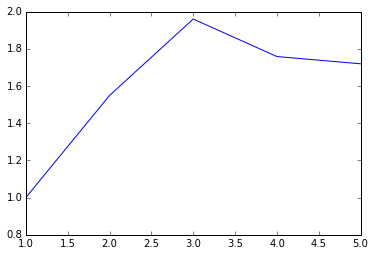

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline
res = [14.7,9.49,7.5,8.36,8.55]
res = map(lambda x: 14.7/x, res)
plt.plot([1,2,3,4,5],res)

In [183]:
res

[1.0, 1.5489989462592202, 1.96, 1.7583732057416268, 1.7192982456140349]

# Checking influence of balancing

In [136]:
rus = RandomUnderSampler(return_indices=True)

In [139]:
dataset_reduced.astype(bool).sum(axis=0)

i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01    3853
i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec    2311
i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0    1905
i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6    1745
i4x://KNU/101/problem/b9daef58e5884fa8b0c36c5c9bd233ce    1529
i4x://KNU/101/problem/7fb5b2515e09416f9977f465f909a746    1410
i4x://KNU/101/problem/e663ed76dc9445dead9354a158daf163    1397
i4x://KNU/101/problem/f1fb3e3d588a4380b7226b87029c284c       0
status                                                    1313
dtype: int64

In [152]:
X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01']]
y = dataset_reduced.status
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("1 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec']]
y = dataset_reduced.status
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("2 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0']]
y = dataset_reduced.status
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("3 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6']]
y = dataset_reduced.status
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("4 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6',
                    'i4x://KNU/101/problem/b9daef58e5884fa8b0c36c5c9bd233ce']]
y = dataset_reduced.status
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("5 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

1 test. Accuracy: 0.89846 (+/- 0.03790)
2 test. Accuracy: 0.94088 (+/- 0.03059)
3 test. Accuracy: 0.96334 (+/- 0.01794)
4 test. Accuracy: 0.96648 (+/- 0.01871)
5 test. Accuracy: 0.98763 (+/- 0.00606)


In [143]:
print len(dataset_reduced['i4x://KNU/101/problem/e663ed76dc9445dead9354a158daf163'])
print len(dataset_reduced.status)

15274
15274


In [254]:
#undersampling
from imblearn.under_sampling import RandomUnderSampler

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01']]
y = dataset_reduced.status
rus = RandomUnderSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("1 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec']]
y = dataset_reduced.status
rus = RandomUnderSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("2 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0']]
y = dataset_reduced.status
rus = RandomUnderSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("3 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6']]
y = dataset_reduced.status
rus = RandomUnderSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("4 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6',
                    'i4x://KNU/101/problem/b9daef58e5884fa8b0c36c5c9bd233ce']]
y = dataset_reduced.status
rus = RandomUnderSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("5 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

NameError: name 'dataset_reduced' is not defined

In [159]:
#oversampling
from imblearn.over_sampling import RandomOverSampler

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01']]
y = dataset_reduced.status
rus = RandomOverSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("1 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec']]
y = dataset_reduced.status
rus = RandomOverSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("2 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0']]
y = dataset_reduced.status
rus = RandomOverSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("3 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6']]
y = dataset_reduced.status
rus = RandomOverSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("4 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6',
                    'i4x://KNU/101/problem/b9daef58e5884fa8b0c36c5c9bd233ce']]
y = dataset_reduced.status
rus = RandomOverSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("5 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

1 test. Accuracy: 0.90606 (+/- 0.02921)
2 test. Accuracy: 0.95061 (+/- 0.01901)
3 test. Accuracy: 0.97074 (+/- 0.01185)
4 test. Accuracy: 0.97400 (+/- 0.00999)
5 test. Accuracy: 0.98979 (+/- 0.00405)


In [255]:
#SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import EditedNearestNeighbours

samplers = [RandomUnderSampler(), RandomOverSampler(), SMOTE(kind='regular'), SMOTE(kind='borderline1'), 
            SMOTE(kind='borderline2'), SMOTE(kind='svm'), ADASYN(),TomekLinks(),OneSidedSelection(),NeighbourhoodCleaningRule(),
           CondensedNearestNeighbour(),ClusterCentroids(),NearMiss(version=1),NearMiss(version=2),NearMiss(version=3),
           AllKNN(),EditedNearestNeighbours(),EditedNearestNeighbours()]

def test_saplers(samplers):
    for sampler in samplers:
        print '==========Sampler {0} starts=========='.format(sampler)
        X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01']]
        y = dataset_reduced.status
        X, y = sampler.fit_sample(X, y)
        scores = cross_val_score(GaussianNB(), X, y,cv=10)
        print("1 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

        X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec']]
        y = dataset_reduced.status
        X, y = sampler.fit_sample(X, y)
        scores = cross_val_score(GaussianNB(), X, y,cv=10)
        print("2 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

        X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                             'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0']]
        y = dataset_reduced.status
        X, y = sampler.fit_sample(X, y)
        scores = cross_val_score(GaussianNB(), X, y,cv=10)
        print("3 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

        X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                             'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6']]
        y = dataset_reduced.status
        X, y = sampler.fit_sample(X, y)
        scores = cross_val_score(GaussianNB(), X, y,cv=10)
        print("4 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

        X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                             'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6',
                            'i4x://KNU/101/problem/b9daef58e5884fa8b0c36c5c9bd233ce']]
        y = dataset_reduced.status
        X, y = sampler.fit_sample(X, y)
        scores = cross_val_score(GaussianNB(), X, y,cv=10)
        print("5 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

        print '==========Sampler finished=========='

NameError: name 'RandomOverSampler' is not defined

In [185]:
class DummySampler():
    def fit_sample(selct, X, y):
        return X, y
    
samplers = [DummySampler(), RandomUnderSampler(), RandomOverSampler(), TomekLinks(),NeighbourhoodCleaningRule(),
            SMOTE(kind='regular'), SMOTE(kind='borderline1'), 
            SMOTE(kind='borderline2'), SMOTE(kind='svm'),
           NearMiss(version=3),AllKNN(),EditedNearestNeighbours(),EditedNearestNeighbours()]

test_saplers(samplers)

==========Sampler <__main__.DummySampler instance at 0x000000004647D688> starts==========
1 test. Accuracy: 0.89846 (+/- 0.03790)
2 test. Accuracy: 0.94088 (+/- 0.03059)
3 test. Accuracy: 0.96334 (+/- 0.01794)
4 test. Accuracy: 0.96648 (+/- 0.01871)
5 test. Accuracy: 0.98763 (+/- 0.00606)
==========Sampler finished==========
==========Sampler RandomUnderSampler(random_state=None, ratio='auto', replacement=True,
          return_indices=False) starts==========
1 test. Accuracy: 0.91011 (+/- 0.06098)
2 test. Accuracy: 0.95239 (+/- 0.01970)
3 test. Accuracy: 0.96611 (+/- 0.02630)
4 test. Accuracy: 0.97069 (+/- 0.02636)
5 test. Accuracy: 0.98896 (+/- 0.01098)
==========Sampler finished==========
==========Sampler RandomOverSampler(random_state=None, ratio='auto') starts==========
1 test. Accuracy: 0.90459 (+/- 0.03407)
2 test. Accuracy: 0.95183 (+/- 0.02053)
3 test. Accuracy: 0.97070 (+/- 0.00902)
4 test. Accuracy: 0.97368 (+/- 0.01008)
5 test. Accuracy: 0.98969 (+/- 0.00373)
==========Sam

# Balancing timing

In [ ]:
samplers = [RandomUnderSampler(), RandomOverSampler(), TomekLinks(),NeighbourhoodCleaningRule(),
            SMOTE(kind='regular'), SMOTE(kind='borderline1'), 
            SMOTE(kind='borderline2'), SMOTE(kind='svm'),
           NearMiss(version=3)]

for sampler in samplers:
    features = pd.

# Final tests

In [21]:
from time import time
features = pd.read_csv('data\\dummy\\ds_x0.csv')

In [9]:
from multiprocessing import Process
def long_job(iterations):
    for i in range(0,iterations):
        pass

i = 100000000
t = time()
long_job(i)
long_job(i)
print 'sequential execution: {0}'.format(time()-t)

t = time()
p1 = Process(target=long_job, args=(i,))
p2 = Process(target=long_job, args=(i,))
p1.start()
p2.start()
p1.join()
p2.join()
print 'parallel execution: {0}'.format(time()-t)

sequential execution: 8.14300012589
parallel execution: 0.602999925613


In [75]:
def sequentialPredict(data):
    print 'start sequential'
    t = time()
    st = t
    X = data[related_columns]
    y = data.status
    sampler = NeighbourhoodCleaningRule()
    X, y = sampler.fit_sample(X, y)
    t1 = time()-t
    t = time()
    model = GaussianNB()
    scores = cross_val_score(model, X, y,cv=10)
    model.fit(X, y)
    t2 = time()-t
    return t1, t2, time()-st

def parallelPredict(data, n):
    print 'start parallel with {0} cores'.format(n)
    t = time()
    st = t
    X = data[related_columns]
    y = data.status
    sampler = NeighbourhoodCleaningRule(n_jobs=n)
    X, y = sampler.fit_sample(X, y)
    t1 = time()-t
    t = time()
    model = GaussianNB()
    scores = cross_val_score(model, X, y,cv=10, n_jobs=n)
    model.fit(X, y)
    t2 = time()-t
    return t1, t2, time()-st

In [28]:
from multiprocessing import Process

def fit_peredict(X, y):
    model.fit(X, y)
    return model.predict(X)
    
def parallelPredictX(data, n):
    X = data[related_columns]
    y = data.status
    if len(data) > 50000:
        sampler = RandomUnderSampler()
    else:
        sampler = NeighbourhoodCleaningRule(n_jobs=n)
    X, y = sampler.fit_sample(X, y)
    model = GaussianNB()
    p1 = Process(target=cross_val_score, args=(model, X, y,None,None,10,n))
    p1.start()
    p2 = Process(target=fit_peredict, args=(X,y))
    p2.start()
    p1.join()
    p2.join()

In [29]:
parallelPredictX(features,3)

IOError: [Errno 32] Broken pipe

In [14]:
len(features)

76370

In [84]:
s_res_s = []
s_res_o = []
s_res = []
a,b,c = sequentialPredict(features)
s_res_s.append(a)
s_res_o.append(b)
s_res.append(c)
cores = [-1,1,2,3,4]
for i in cores:
    a, b, c = parallelPredict(features, i)
    s_res_s.append(a)
    s_res_o.append(b)
    s_res.append(c)

start sequential
start parallel with -1 cores
start parallel with 1 cores
start parallel with 2 cores
start parallel with 3 cores
start parallel with 4 cores


In [85]:
x_res_s = []
x_res_o = []
x_res = []
a,b,c = sequentialPredict(features)
x_res_s.append(a)
x_res_o.append(b)
x_res.append(c)
for i in cores:
    a, b, c = parallelPredictX(features, i)
    x_res_s.append(a)
    x_res_o.append(b)
    x_res.append(c)

start sequential


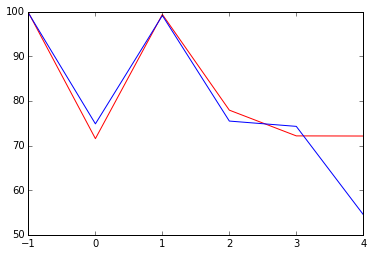

In [86]:
x = np.array([-1,0,1,2,3,4])
y1 = np.array(s_res)
y2 = np.array(x_res)
plt.plot(x, y1, 'r', x, y2, 'b')
plt.show()

In [82]:
print s_res
print x_res

[3.427999973297119, 3.7799999713897705, 3.36899995803833, 3.690000057220459, 3.5859999656677246, 3.0999999046325684]
[3.3610000610351562, 3.805999994277954, 3.493000030517578, 3.819000005722046, 3.680000066757202, 3.8330001831054688]


In [57]:
np.ndarray(cores)

ValueError: negative dimensions are not allowed